In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import *
import sklearn.model_selection
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_extraction.text import *
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import logging

import emot

import pickle

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Client support

# 1. Data extraction

In [2]:
filename = "../../data/extraction_twint/tweets_data/data_service_clients/with_reply_time/amazon.csv"

In [3]:
full_df = pd.read_csv(filename)
df = full_df[["tweet","reply_time"]].copy()
df= df.rename(columns={'tweet':'raw'})

In [4]:
full_df.columns

Index(['id', 'conversation_id', 'created_at', 'timezone', 'user_id',
       'username', 'name', 'place', 'tweet', 'mentions', 'urls', 'photos',
       'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest', 'datetime',
       'reply_time'],
      dtype='object')

In [5]:
full_df.head()

,id,conversation_id,created_at,timezone,user_id,username,name,place,tweet,mentions,...,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,datetime,reply_time
0,1230146321983688704,1230143862439661577,1582124712000,Romance Standard Time,2811237630,olddaysb2,بَدْر MBS🇸🇦💙,NaN,No I did not only Before they asked my to canc...,['amazonhelp'],...,NaN,NaN,NaN,"[{'user_id': '2811237630', 'username': 'oldday...",NaN,NaN,NaN,NaN,2020-02-19 16:05:12,NaN
1,1230145753336598528,1230015909940670464,1582124577000,Romance Standard Time,1228467717025533959,jessjones214,Jessica Jones,NaN,Pretty pretty please! #SanditonPBS,"['amazonhelp', 'tweetkp2011']",...,NaN,NaN,NaN,"[{'user_id': '1228467717025533959', 'username'...",NaN,NaN,NaN,NaN,2020-02-19 16:02:57,NaN
2,1230145679101714432,1230126971360808962,1582124559000,Romance Standard Time,565836447,5hkehlaniacpb,BTS🖤,NaN,When the supernatural series have finished do ...,['amazonhelp'],...,NaN,NaN,NaN,"[{'user_id': '565836447', 'username': '5hkehla...",NaN,NaN,NaN,NaN,2020-02-19 16:02:39,NaN
3,1230145620666544128,1229734729731256320,1582124545000,Romance Standard Time,1043681517204066304,azharan27376416,Azhar Ahmad Ansari,NaN,"Visited this link, made complain on customer c...",['amazonhelp'],...,NaN,NaN,NaN,"[{'user_id': '1043681517204066304', 'username'...",NaN,NaN,NaN,NaN,2020-02-19 16:02:25,NaN
4,1230145534855241728,1230141256010887170,1582124525000,Romance Standard Time,727785110213304320,pshabbir36,Shabbir Hussain,NaN,Using same account still this pic.twitter.com/...,['amazonhelp'],...,NaN,NaN,NaN,"[{'user_id': '727785110213304320', 'username':...",NaN,NaN,NaN,NaN,2020-02-19 16:02:05,NaN


In [6]:
df.columns

Index(['raw', 'reply_time'], dtype='object')

In [7]:
df.head()

,raw,reply_time
0,No I did not only Before they asked my to canc...,NaN
1,Pretty pretty please! #SanditonPBS,NaN
2,When the supernatural series have finished do ...,NaN
3,"Visited this link, made complain on customer c...",NaN
4,Using same account still this pic.twitter.com/...,NaN


In [8]:
df.shape

(2191, 2)

In [9]:
sum(df.reply_time.isnull())

491

In [10]:
#reply time to timedelta
df['reply_time']=df['reply_time'].map(pd.to_timedelta)

#reply time in minutes
df['reply_time']=df['reply_time'].map(lambda x: x.days*1440 + x.seconds//60)

In [11]:
df["raw"] = df["raw"].astype(str)

In [12]:
df.dtypes

raw            object
reply_time    float64
dtype: object

# 2. Pre-processing

In [13]:
df['has_reply'] = df['reply_time'].map(lambda x : not(math.isnan(x)))

In [14]:
df['has_reply'].value_counts()

True     1700
False     491
Name: has_reply, dtype: int64

In [15]:
print ("Pourcentage de tweets répondus")
len(df[df['has_reply']==True])*100/len(df)

Pourcentage de tweets répondus


77.59014148790507

### Change text

In [16]:
def remove_uppercase(text):
    return text.lower()
    
def remove_punctuation(text):
    """custom function to remove the punctuation"""  
    PUNCT_TO_REMOVE = string.punctuation
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_frequent_words(text):
    FREQWORDS = get_frequent_words(df)
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

# def remove_urls(text):
#     url_pattern = re.compile(r'https?://\S+|www\.\S+')
#     expression = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*')
#     text =  url_pattern.sub(r'', text)
#     return expression.sub(r'', text)

def remove_urls(text):
    words=[]
    for w in text.split(" "):
        if not(w.startswith("http") or w.startswith("www") or w.startswith("pic.twitter")):
            words+=[w]
    return ' '.join(words)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'[0-9\.]+', '', text)




In [17]:
def get_frequent_words(column):
    cnt = Counter()
    for text in column.values:
        for word in text.split():
            cnt[word] += 1
    FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
    #RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-10-1:-1]])
    return FREQWORDS

get_frequent_words(df.raw)

{'I', 'a', 'and', 'for', 'is', 'it', 'my', 'the', 'to', 'you'}

### Emoticons to words

In [18]:
def convert_emojis(text):
    emo= emot.emoji(text)
    for i in range(len(emo['value'])):
        text = text.replace(emo['value'][i], emo['mean'][i]).replace(":","")
    return text

text = "game is on 🔥 🔥 😭"
print(convert_emojis(text))

game is on fire fire loudly_crying_face


### Chat words conversion

In [19]:
words = "../../source/slang.txt"
with open(words, 'r') as file:
    chat_words_str = file.read()

In [20]:
chat_words_map_dict = {}
chat_words_list = []

for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

chat_words_conversion("one minute BRB")

'one minute Be Right Back'

In [21]:
#df.raw.apply(chat_words_conversion)

### Stemming

In [22]:
#not so good results

def stem_words(text):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

#df["stemmed"] = df["raw"].apply(lambda text: stem_words(text))
#df.head()

### Lemmatization

In [23]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) 
                     for word, pos in pos_tagged_text])
    #return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

ex = "hello I am buying a fruit"
lemmatize_words(ex)
#df["raw_lemmatized"] = df["raw"].apply(lambda text: lemmatize_words(text))
#df.head()

'hello I be buy a fruit'

### Tokenisation

In [24]:
import re

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

#df['tweet_tokenized']=df["tweet_lower"].apply(lambda text: tokenize(text))

# 3. Feature engineering

### Tweet length

In [25]:
df['length']=df['raw'].apply(lambda x:len(x)-x.count(" "))

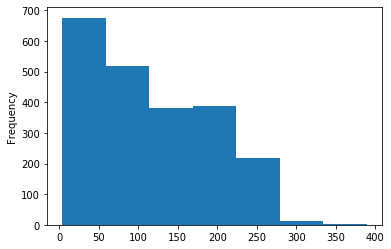

In [26]:
df.length.plot.hist(bins=7)

### Punctuation percentage

In [27]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")),3)*100

df['punct']=df['raw'].apply(count_punct)

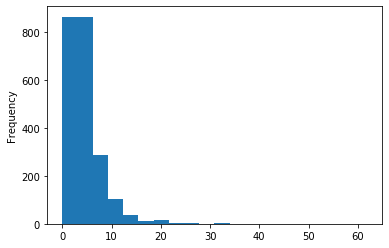

In [28]:
df.punct.plot.hist(bins=20)

In [29]:
df.punct.describe()

count    2191.000000
mean        4.394843
std         4.024036
min         0.000000
25%         2.200000
50%         3.700000
75%         5.700000
max        61.800000
Name: punct, dtype: float64

# 4. Data analysis

C:\Users\carol\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\carol\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


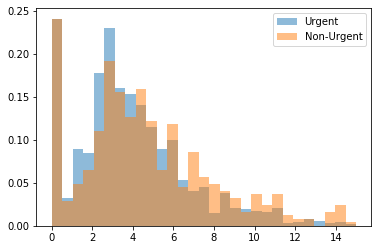

In [30]:
bins=np.linspace(0,15,30)
plt.hist(df[df.has_reply==True]['punct'],bins, alpha=0.5, normed=True, label='Urgent')
plt.hist(df[df.has_reply==False]['punct'],bins, alpha=0.5, normed=True, label='Non-Urgent')
plt.legend(loc='upper right')
plt.show()

Les features calculées n'ont pas l'air de différencier les tweets

In [31]:
df.reply_time.describe()

count    1700.000000
mean       12.892353
std        70.875486
min         0.000000
25%         2.000000
50%         5.000000
75%         9.000000
max      1354.000000
Name: reply_time, dtype: float64

Temps médian de réponse : 5min
Temps moyen de réponse : 13min

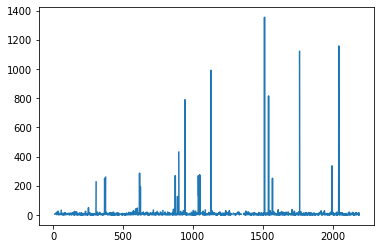

In [32]:
#Distribution of reply times
plt.plot(df['reply_time'])

# 5. Models

# 5A. Model creation 

## 1. Final pre-processing

In [33]:
df["clean_tweet"] = df["raw"].apply(lambda text: remove_uppercase(text))
df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_punctuation(text))
df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_stopwords(text))
#df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_frequent_words(text))
df["clean_tweet"] = df["clean_tweet"].apply(lambda text: lemmatize_words(text))

In [34]:
df["clean_tweet"] = df["clean_tweet"].apply(lambda text: chat_words_conversion(text))

In [35]:
df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_urls(text))

In [36]:
df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_numbers(text))

In [37]:
df.shape

(2191, 6)

In [38]:
# Remove small tweets
df = df[df['clean_tweet'].apply(lambda x: len(x) > 3)]

In [39]:
df.shape

(2175, 6)

In [40]:
get_frequent_words(df.clean_tweet)

{'account',
 'amazon',
 'amazonhelp',
 'call',
 'customer',
 'get',
 'order',
 'please',
 'say',
 'time'}

In [41]:
df["clean_tweet_tokenized"] = df["clean_tweet"].apply(lambda text: tokenize(text))

In [42]:
df.columns

Index(['raw', 'reply_time', 'has_reply', 'length', 'punct', 'clean_tweet',
       'clean_tweet_tokenized'],
      dtype='object')

### Create dataset

In [44]:
# count_vect = CountVectorizer()
# X = matrix.fit_transform(df.clean_tweet).toarray()

In [ ]:
# Choose value to predict
y = df.has_reply

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.80,random_state=44)

## 2. Vectorization

####  Bag Of Words

In [96]:
def bow_encode(text):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text)
    print("Vocab size is: ", len(vectorizer.get_feature_names()))
    return X

In [46]:
np.unique(bow_encode(df.clean_tweet).toarray())

Vocab size is:  4096


array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

Visualize Bag Of Words

Vocab size is:  4096


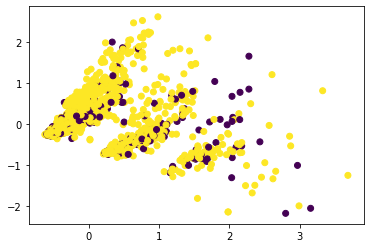

In [47]:
X = bow_encode(df.clean_tweet).todense()
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=df.has_reply)

In [97]:
def tfidf_encode(text):
    tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
    return tfidf_vectorizer.fit_transform(text)

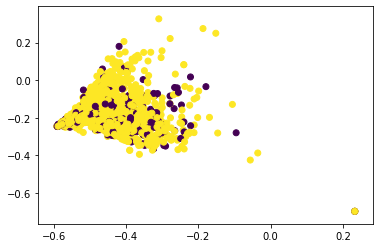

In [98]:
Z = tfidf_encode(df.clean_tweet).todense()
pca = PCA(n_components=2).fit(X)
Z_data2D = pca.transform(Z)
plt.scatter(Z_data2D[:,0], Z_data2D[:,1], c=df.has_reply)

In [79]:
def build_features(df, field, training_data, testing_data, type="count"):
    
    logging.info("Extracting features and creating vocabulary...")

   
    if 'count' in type:
        cv= CountVectorizer(binary=False, max_df=0.95)
        #fit on training data
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    if 'tfidf' in type:
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer
     
    if "binary" in type:
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
 
    #add n-gram
    else:
        raise ValueError('Mode should be either count or tfidf')

## 3. Choose model

### Logistic Regression / Naive Bayes / Random Forest

In [108]:
def try_model(model, encode_type, df):
    training_data, testing_data = train_test_split(df,random_state = 2000)

    y_train=training_data['has_reply'].values
    y_test=testing_data['has_reply'].values

    X_train,X_test,feature_transformer=build_features(df,'clean_tweet',
                                                        training_data,testing_data,type=encode_type)
    logging.info("Training the Model...")

    clf=model.fit(X_train,y_train)
    
    preds = clf.predict(X_test)
    print(metrics.classification_report(y_test, preds))
    print_scores(y_test,preds)
    display_roc_curve(y_test,X_test, model)
    get_confusion_matrix(X_test, y_test, model)

              precision    recall  f1-score   support

       False       0.33      0.11      0.16       119
        True       0.79      0.94      0.86       425

    accuracy                           0.76       544
   macro avg       0.56      0.52      0.51       544
weighted avg       0.69      0.76      0.71       544

RESULTATS 
     Accuracy  : 75.74% 
     F1 score  : 0.8581
     Precision : 79.01% (how many selected items are relevant)
     Recall    : 93.88% (how many relevant items are selected)
     

    STATISTICS
     Proportion of positives in test set    : 78.12%
     Proportion of positives in predictions : 92.83%    


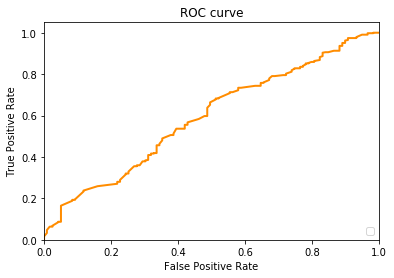

Confusion matrix, without normalization
[[ 13 106]
 [ 26 399]]
Normalized confusion matrix
[[0.1092437  0.8907563 ]
 [0.06117647 0.93882353]]


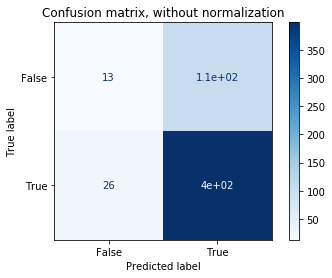

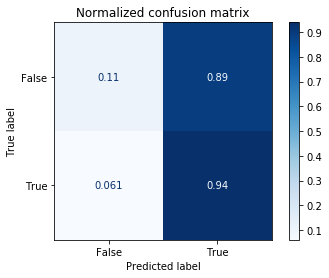

In [110]:
#model = LogisticRegression()
#model = MultinomialNB()
model = RandomForestClassifier()
#model = LinearSVC()
#xgboost 
encode_type = "count"
try_model(model, encode_type, df)

# 5B. Model evaluation

In [ ]:
print('Performance on test set :')
print('\n')

print('Accuracy : %.3f ' % accuracy_score(y_test, y_pred))


### Feature importance

### Confusion Matrix

In [59]:
## PRINT SCORES

def print_scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1_score_val = f1_score(y_test, y_pred)
    precision_score_val = precision_score(y_test, y_pred)
    recall_score_val = recall_score(y_test, y_pred)


    string = "RESULTATS \n \
    Accuracy  : {accuracy}% \n \
    F1 score  : {f1_score}\n \
    Precision : {precision}% (how many selected items are relevant)\n \
    Recall    : {recall}% (how many relevant items are selected)\n \
    \n\n\
    STATISTICS\n\
     Proportion of positives in test set    : {positives}%\n\
     Proportion of positives in predictions : {predicted_positives}%\
    "

    print(string.format(accuracy = round(100*accuracy,2),
                        f1_score = round(f1_score_val,4), 
                        precision = round(100*precision_score_val,2), 
                        recall = round(100*recall_score_val,2),
                        positives = round(100*y_test.sum()/len(y_test),2),
                        predicted_positives = round(100*y_pred.sum()/len(y_pred),2),
                       ))

### ROC Curve

In [74]:
## DISPLAY ROC CURVE
def display_roc_curve(y_test, X_test, model):
    roc_curve_val = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

    plt.plot(roc_curve_val[0], roc_curve_val[1], color='darkorange',
             lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

### Confusion Matrix

In [76]:
# CONFUSION MATRIX
def get_confusion_matrix(X_test, y_test, model):
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

#### Feature Importance 

In [111]:
def importance_plotting(data,x,y,palette,title):
    sns.set(style="whitegrid")
    ft = sns.PairGrid(data,y_vars=y,x_vars=x,size=5,aspect=1)
    ft.map(sns.stripplot,orient='h',palette=palette, edgecolor="black",size=15)
    for ax, title in zip(ft.axes.flat, titles):
        
    # Set a different title for each axes
        ax.set(title=title)
        
    # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    plt.show()

In [113]:
model.feature_importances_.shape

(3471,)

In [114]:
X.shape

(2175, 4096)

In [112]:
# Compile arrays of columns (words) and feature importances
fi = {'Words':df.columns.tolist(),'Importance':model.feature_importances_}

# Bung these into a dataframe, rank highest to lowest then slice top 20
Importance = pd.DataFrame(fi,index=None).sort_values('Importance',ascending=False).head(25)

# Plot the graph!
titles = ["Top 25 most important words in predicting product recommendation"]
importance_plotting(Importance,'Importance','Words','Greens_r',titles)

ValueError: arrays must all be same length

In [ ]:
features = pd.DataFrame()
features['importance'] = rf.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)

In [ ]:
features.head()

In [107]:
from sklearn import metrics

In [ ]:
features.plot(kind='barh', figsize=(10, 8))
plt.title('Most important features')
plt.show()

# 5C. Save Model